In [0]:
%%bash

# install edgetpu_compiler
echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
sudo apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 6A030B21BA07F4FB

sudo apt update > /dev/null
sudo apt install edgetpu > /dev/null

# install tensorflow 2.0
pip install tensorflow-gpu==2.0-beta1

deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Executing: /tmp/apt-key-gpghome.xLwbjpgTJz/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 6A030B21BA07F4FB


gpg: key 6A030B21BA07F4FB: "Google Cloud Packages Automatic Signing Key <gc-team@google.com>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1






## Build CNN AutoEncoder with Keras

In [0]:
%matplotlib inline

import logging
logging.basicConfig(level=logging.INFO)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt


print(f'TensorFlow\'s version: {tf.__version__}')

TensorFlow's version: 2.0.0-beta1


In this notebook we use Fashion MNIST

In [0]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = train_images[:, :, :, np.newaxis].astype(np.float32)
test_images = test_images[:, :, :, np.newaxis].astype(np.float32)

Build Model

In [0]:
# UpSampling2D (using nearest neighber) is not supported yet.
# We should implement it by myself.
def UpSampling2D(scale=(2, 2)):
    if isinstance(scale, int):
        scale = (scale, scale)

    def upsampling(x):
        shape = x.shape
        x = keras.layers.Concatenate(-2)([x]*scale[0])
        x = keras.layers.Reshape([shape[1]*scale[0], shape[2], shape[3]])(x)
        x = keras.layers.Concatenate(-1)([x]*scale[1])
        x = keras.layers.Reshape([shape[1]*scale[0], shape[2]*scale[1], shape[3]])(x)
        return x
    
    return upsampling

In [0]:
def build_keras_model(hidden_size=2):
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(16, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(8, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Flatten()(x)
    encoded = layers.Dense(hidden_size)(x)
    
    x = layers.Dense(7*7*8)(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((7, 7, 8))(x)
    x = UpSampling2D()(x)
    # x = layers.UpSampling2D(2, interpolation='bilinear')(x)
    x = layers.Conv2D(8, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = UpSampling2D()(x)
    # x = layers.UpSampling2D(2, interpolation='bilinear')(x)
    x = layers.Conv2D(16, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, decoded)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return model

In [0]:
model = build_keras_model()
model.summary()
model.fit(train_images, train_images, epochs=1)
model.save('model.h5')

W0619 03:01:46.640446 140399009306496 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

We need small dataset to calibrate quantization parameters.

In [0]:
def representative_dataset_gen():
    for i in range(1000):
        yield [train_images[i: i + 1]]
        

# Currentry, it seems that tf.lite.TFLiteConverter does not suppert inference_input/output_type yet.
# So we have to use tf.compat.v1.lite.TFLiteConverter.
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file('model.h5')
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
with open('model.tflite', 'wb') as o_:
    o_.write(tflite_model)
    
    
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_dataset_gen
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# tflite_model = converter.convert()

# with open('model.tflite', 'wb') as o_:
#     o_.write(tflite_model)

I0619 03:02:16.462525 140399009306496 convert_to_constants.py:238] Converted 40 variables to const ops.


We can validate the tflite model using tf.lite.Interpreter.

original_image:


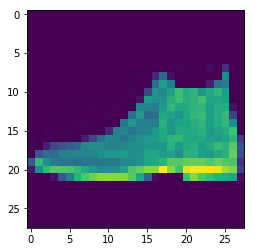

prediced by original model: 


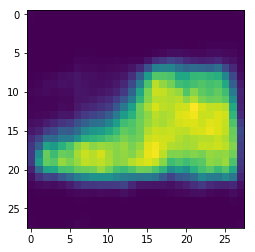

predicted by quantized_model


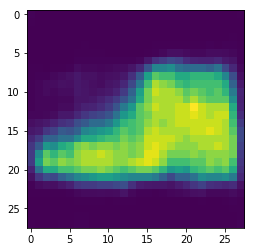

In [0]:
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

input_detail = interpreter.get_input_details()[0]
output_detail = interpreter.get_output_details()[0]

def quantize(real_value):
    std, mean = input_detail['quantization']
    return (real_value/std + mean).astype(np.uint8)

sample_input = quantize(test_images[0]).reshape(input_detail['shape'])

interpreter.set_tensor(input_detail['index'], sample_input)
interpreter.invoke()

original_image = test_images[0].reshape((28, 28))
pred_original_model = model.predict(test_images[:1]).reshape((28, 28))
pred_quantized_model =  interpreter.get_tensor(output_detail['index']).reshape((28, 28))

print('original_image:')
plt.imshow(original_image)
plt.show()
print('prediced by original model: ')
plt.imshow(model.predict(test_images[:1]).reshape((28, 28)))
plt.show()
print('predicted by quantized_model')
plt.imshow(pred_quantized_model.reshape((28, 28)))
plt.show()

In [0]:
%%bash

edgetpu_compiler --show_operations 'model.tflite'

Edge TPU Compiler version 1.0.249710469

Model compiled successfully in 89 ms.

Input model: model.tflite
Input size: 15.63KiB
Output model: model_edgetpu.tflite
Output size: 132.55KiB
On-chip memory available for caching model parameters: 7.82MiB
On-chip memory used for caching model parameters: 57.50KiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 22
Operation log: model_edgetpu.log

Operator                       Count      Status

CONCATENATION                  4          Mapped to Edge TPU
QUANTIZE                       2          Mapped to Edge TPU
CONV_2D                        5          Mapped to Edge TPU
DEPTHWISE_CONV_2D              1          Mapped to Edge TPU
RESHAPE                        5          Mapped to Edge TPU
FULLY_CONNECTED                2          Mapped to Edge TPU
LOGISTIC                       1          Mapped to Edge TPU
MAX_POOL_2D                    2          Mapped to

INFO: Initialized TensorFlow Lite runtime.


In [0]:
from google.colab import files

files.download('model_edgetpu.tflite')